# External Dataset Testing (Notebook)

This notebook tests the trained InSDN model on external datasets and visualizes how external columns map to the model's expected features.


In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For model + testing utilities
from test_external import ExternalDatasetTester

sns.set_style("whitegrid")


## Step 1: Configuration and dataset discovery


In [2]:
MODEL_DIR = "../output"  # trained model artifacts
DATA_DIR = Path("./external_data")

# Dataset registry: expected filenames/patterns
DATASET_REGISTRY = {
    'CSE-CIC-IDS2018': {
        'patterns': ['02-20-2018.csv', '*IDS2018*.csv'],
        'label_column': None,  # auto-detect
        'description': 'CSE-CIC-IDS2018 Dataset'
    },
    'CIC-IDS2017-Friday-DDoS': {
        'patterns': ['Friday-DDos-MAPPED.csv', 'Friday*DDoS*.csv', 'Friday*DDos*.csv'],
        'label_column': None,  # auto-detect
        'description': 'CIC-IDS2017 Friday DDoS (Mapped)'
    }
}


def find_datasets(data_dir: Path):
    found = []
    if not data_dir.exists():
        return found
    for name, cfg in DATASET_REGISTRY.items():
        for pat in cfg['patterns']:
            # exact match first
            exact = data_dir / pat
            if exact.exists() and exact.is_file():
                found.append({
                    'name': name,
                    'path': str(exact),
                    'label_column': cfg['label_column'],
                    'description': cfg['description'],
                })
                break
            # glob pattern
            matches = list(data_dir.glob(pat))
            if matches:
                found.append({
                    'name': name,
                    'path': str(matches[0]),
                    'label_column': cfg['label_column'],
                    'description': cfg['description'],
                })
                break
    return found


datasets = find_datasets(DATA_DIR)
print(f"Found {len(datasets)} dataset(s) in {DATA_DIR}:")
for ds in datasets:
    print(f"  - {ds['name']}: {ds['path']}")

if not datasets:
    raise SystemExit("No datasets found. Place CSVs in external_data/ and rerun.")


Found 2 dataset(s) in external_data:
  - CSE-CIC-IDS2018: external_data\02-20-2018.csv
  - CIC-IDS2017-Friday-DDoS: external_data\Friday-DDos-MAPPED.csv


## Step 2: Select a dataset to test

Edit `selected_idx` if you want to pick a different dataset.


In [3]:
selected_idx = 0  # change to 1,2,... if multiple datasets

if selected_idx >= len(datasets):
    raise IndexError(f"selected_idx={selected_idx} out of range; only {len(datasets)} dataset(s) found.")

selected = datasets[selected_idx]
print(f"Selected dataset: {selected['name']}")
print(f"Path: {selected['path']}")


Selected dataset: CSE-CIC-IDS2018
Path: external_data\02-20-2018.csv


## Step 3: Load trained model


In [4]:
tester = ExternalDatasetTester(model_dir=MODEL_DIR)
tester.load_model()
print(f"Model expects {len(tester.feature_names)} features\n")


LOADING TRAINED MODEL
[+] Model loaded from ../output\final_model.keras
[+] Preprocessor loaded from ../output\preprocess.joblib
[+] Label encoder loaded from ../output\label_encoder.joblib
[+] Expected features: 25

Model expects 25 features



## Step 4: Load external dataset and detect label


In [5]:
df, detected_label_col = tester.load_external_dataset(selected['path'], selected['label_column'])
label_col = selected['label_column'] if selected['label_column'] else detected_label_col
print(f"Using label column: {label_col}")
print("Shape:", df.shape)
print("Label distribution:\n", df[label_col].value_counts())


LOADING EXTERNAL DATASET
[+] Detected CSV format
[+] Loaded dataset: external_data\02-20-2018.csv
[+] Shape: (7948748, 84)
[+] Columns: 84
[+] Using label column: 'Label'

Label distribution:
Label
Benign                    7372557
DDoS attacks-LOIC-HTTP     576191
Name: count, dtype: int64

Using label column: Label
Shape: (7948748, 84)
Label distribution:
 Label
Benign                    7372557
DDoS attacks-LOIC-HTTP     576191
Name: count, dtype: int64


## Step 5: Visualize column mapping (external vs model)

- **Common**: columns present in both external data and expected features
- **Missing**: expected by model but not in external data (will be imputed)
- **Extra**: present in external data but not used by model


Common:  25
Missing: 0
Extra:   54


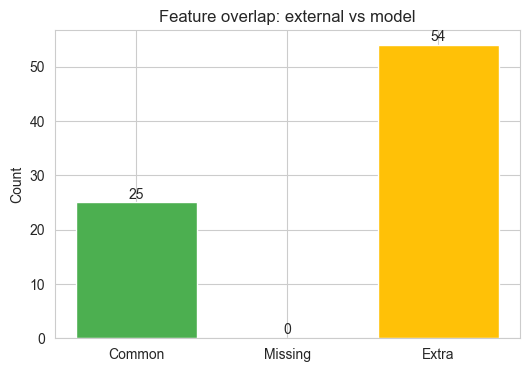


Missing features (model expects, not in external) - first 15:
Series([], dtype: object)

Extra features (in external, not used by model) - first 15:
0         ACK Flag Cnt
1           Active Max
2          Active Mean
3           Active Min
4           Active Std
5     Bwd Blk Rate Avg
6       Bwd Byts/b Avg
7          Bwd IAT Max
8         Bwd IAT Mean
9          Bwd IAT Std
10         Bwd IAT Tot
11       Bwd PSH Flags
12     Bwd Pkt Len Max
13    Bwd Pkt Len Mean
14      Bwd Pkts/b Avg
dtype: object


In [6]:
# Columns to exclude from features (aligned with tester.prepare_features)
exclude_cols = [
    label_col,
    'Flow ID', 'flow_id', 'FlowID',
    'Src IP', 'src_ip', 'Source IP', 'SrcIP',
    'Dst IP', 'dst_ip', 'Destination IP', 'DstIP', 'Dest IP',
    'Timestamp', 'timestamp', 'Time', 'time',
    'Source', 'Destination', 'id', 'ID'
]

X_raw = df.copy()
for col in exclude_cols:
    if col in X_raw.columns:
        X_raw = X_raw.drop(columns=[col])

expected = set(tester.feature_names)
actual = set(X_raw.columns)

common = expected & actual
missing = expected - actual
extra = actual - expected

print(f"Common:  {len(common)}")
print(f"Missing: {len(missing)}")
print(f"Extra:   {len(extra)}")

# Bar chart
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(['Common','Missing','Extra'], [len(common), len(missing), len(extra)], color=['#4CAF50','#F44336','#FFC107'])
ax.set_title('Feature overlap: external vs model')
ax.set_ylabel('Count')
for i,v in enumerate([len(common), len(missing), len(extra)]):
    ax.text(i, v+0.2, str(v), ha='center', va='bottom')
plt.show()

# Show sample of missing/extra
print("\nMissing features (model expects, not in external) - first 15:")
print(pd.Series(sorted(missing)).head(15))
print("\nExtra features (in external, not used by model) - first 15:")
print(pd.Series(sorted(extra)).head(15))


## Step 6: Prepare features (aligned to model)


In [7]:
# Prepare features using the same logic as the tester
X_aligned, _ = tester.prepare_features(df, label_col)
print("Aligned shape:", X_aligned.shape)
# Verify ordering matches model expectation
assert list(X_aligned.columns) == tester.feature_names
print("Columns aligned to model expectations.")


PREPARING FEATURES
[+] Features shape: (7948748, 79)
[+] Labels shape: (7948748,)

[*] Feature Comparison:
  Common features: 25
  Missing from external dataset: 0
  Extra in external dataset: 54
[+] Features aligned to training schema

Aligned shape: (7948748, 25)
Columns aligned to model expectations.


## Step 7: Map labels to binary


In [8]:
y_binary = tester.map_labels_to_binary(df[label_col])
print(y_binary.value_counts())


MAPPING LABELS TO BINARY
Original unique labels: 2
Mapped to binary:
  Attack: 576,191 (7.2%)
  Normal: 7,372,557 (92.8%)

Normal    7372557
Attack     576191
Name: count, dtype: int64


## Step 8: Predict and evaluate


In [9]:
# Transform & predict
X_transformed = tester.preprocessor.transform(X_aligned).astype("float32")
print("Transformed shape:", X_transformed.shape)

y_pred, y_prob = tester.predict(X_aligned)

tester.evaluate(y_binary, y_pred, y_prob, output_dir=f"./results/{selected['name']}")


Transformed shape: (7948748, 25)
MAKING PREDICTIONS
Transforming features...
[+] Transformed shape: (7948748, 25)
Running model inference...
[+] Predictions complete

EVALUATION RESULTS

OVERALL METRICS
Accuracy:  0.6614 (66.14%)
ROC AUC:   0.7590
Avg Precision: 0.9730

CONFUSION MATRIX
[[ 327986  248205]
 [2443009 4929548]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Attack     0.1184    0.5692    0.1960    576191
      Normal     0.9521    0.6686    0.7856   7372557

    accuracy                         0.6614   7948748
   macro avg     0.5352    0.6189    0.4908   7948748
weighted avg     0.8916    0.6614    0.7428   7948748

[+] Confusion matrix saved: ./results/CSE-CIC-IDS2018\confusion_matrix_external.png
[+] ROC curve saved: ./results/CSE-CIC-IDS2018\roc_curve_external.png
[+] Precision-Recall curve saved: ./results/CSE-CIC-IDS2018\precision_recall_external.png

[+] Results saved to ./results/CSE-CIC-IDS2018
[+] Text report: ./results/CSE-

### How to read the plots
- **Confusion Matrix (counts)**: rows = true, cols = predicted; off-diagonals are errors.
- **ROC Curve**: AUC close to 1 is better; diagonal is random.
- **Precision-Recall Curve**: Shows precision trade-off vs recall; AP close to 1 is better.
- Metrics shown below the plots: accuracy, ROC AUC, Average Precision, support, and full classification report.


## Step 9: Visualize evaluation (inline)

Plots: confusion matrix, ROC, Precision-Recall.


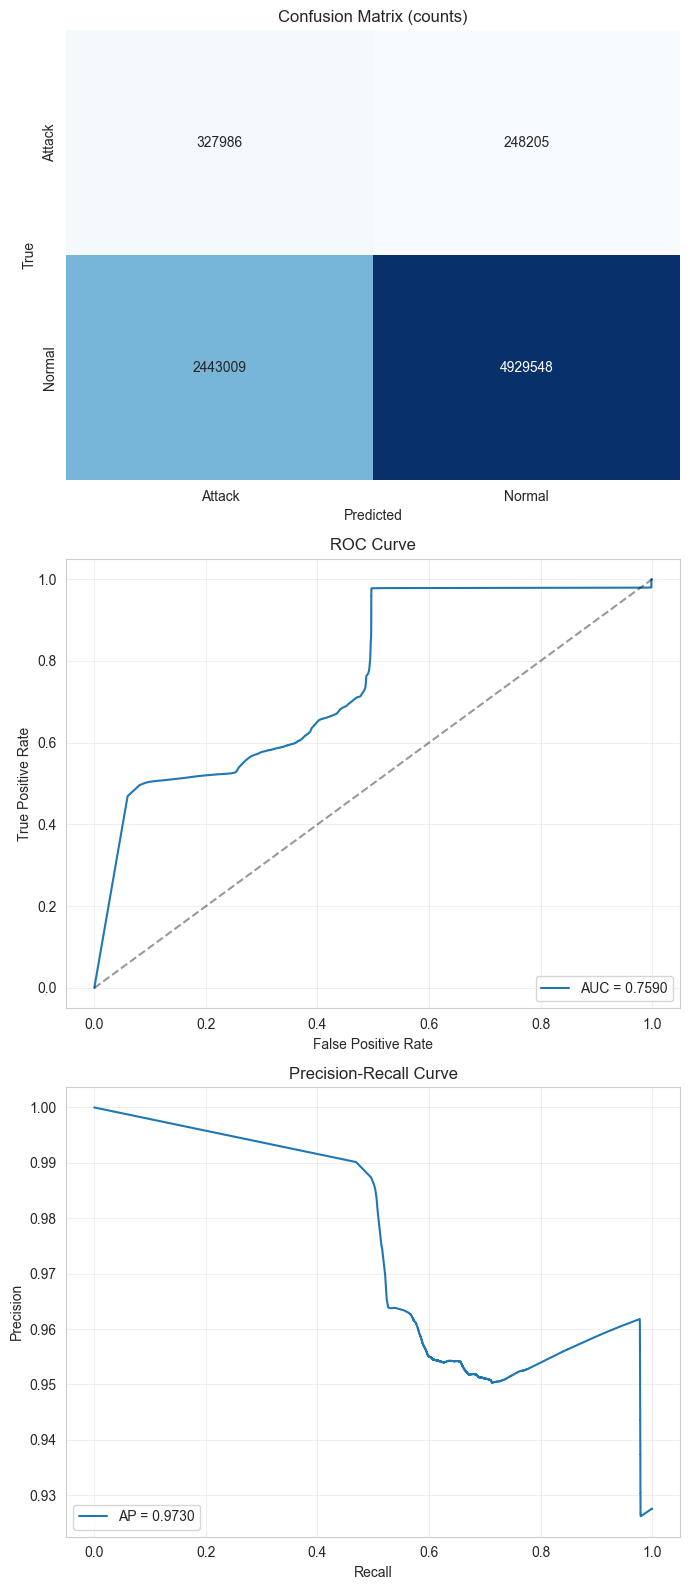

{'accuracy': 0.6614291961451036, 'roc_auc': 0.7589734737457716, 'average_precision': 0.9729887813456937, 'support': 7948748}

Classification report:
               precision    recall  f1-score   support

      Attack       0.12      0.57      0.20    576191
      Normal       0.95      0.67      0.79   7372557

    accuracy                           0.66   7948748
   macro avg       0.54      0.62      0.49   7948748
weighted avg       0.89      0.66      0.74   7948748

Saved inline plots to: ./results/CSE-CIC-IDS2018/inline_eval.png


In [15]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report
import os

# Encode true labels to match model encoding
y_true_enc = tester.label_encoder.transform(y_binary)
class_labels = list(tester.label_encoder.classes_)

# Stack plots vertically for better readability
fig, ax = plt.subplots(3, 1, figsize=(7, 16))

# Confusion matrix (counts only)
cm = confusion_matrix(y_true_enc, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0], cbar=False)
ax[0].set_title("Confusion Matrix (counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")
ax[0].set_xticklabels(class_labels)
ax[0].set_yticklabels(class_labels)

# ROC curve
fpr, tpr, _ = roc_curve(y_true_enc, y_prob)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
ax[1].plot([0,1], [0,1], "k--", alpha=0.4)
ax[1].set_title("ROC Curve")
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].legend(loc="lower right")
ax[1].grid(True, alpha=0.3)

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true_enc, y_prob)
avg_prec = average_precision_score(y_true_enc, y_prob)
ax[2].plot(recall, precision, label=f"AP = {avg_prec:.4f}")
ax[2].set_title("Precision-Recall Curve")
ax[2].set_xlabel("Recall")
ax[2].set_ylabel("Precision")
ax[2].legend(loc="lower left")
ax[2].grid(True, alpha=0.3)

plt.tight_layout()

# Save plots to results folder
os.makedirs("./results", exist_ok=True)
safe_name = selected['name'].replace(' ', '_').replace('/', '_')
plot_path = f"./results/{safe_name}/inline_eval.png"
os.makedirs(f"./results/{safe_name}", exist_ok=True)
plt.savefig(plot_path, dpi=120, bbox_inches="tight")
plt.show()

metrics = {
    "accuracy": float((y_true_enc == y_pred).mean()),
    "roc_auc": float(roc_auc),
    "average_precision": float(avg_prec),
    "support": len(y_true_enc),
}
print(metrics)
print("\nClassification report:\n", classification_report(y_true_enc, y_pred, target_names=class_labels))
print(f"Saved inline plots to: {plot_path}")
